In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from copy import deepcopy

from typing import List, Tuple, Dict

# Read Data

In [3]:
dataset = pd.read_excel("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/heatpumps/NEEP_Database.xlsx")


In [4]:
col_names = list(dataset.columns)
for name in col_names:
    print(name)

Status
Brand Name
Series Name
AHRI Certified Reference No.
Old AHRI Certified Reference No.
AHRI Type
Outdoor Unit Model
Indoor Unit Type
Indoor Model(s)
Furnace Model Number (if applicable)
EER (@ 95°F)
EER 2 (@ 95°F)
SEER
SEER 2
HSPF (Region IV)
HSPF (Region IV) 2
HSPF (Region V) 2
ENERGY STAR Certified
ENERGY STAR Cold Climate Certified
Ducting Configuration
Variable Capacity?
Turndown Ratio
Capacity Maintenance (Max 5°F/Max 47°F)
Capacity Maintenance (Rated 17°F/Rated 47°F)
Capacity Maintenance (Max 5°F/Rated 47°F)
Integrated or Accessory (provide model #)
Input Power (W)
What determines when heater operates?
Integration- Describe any capabilities this ASHP system or its controller(s) have related to integration other heating systems/third-party thermostats including “works with”, etc.
Connectivity: Describe any capabilities this ASHP system or its controller(s) have related to communication with the consumer or utility (i.e. Does the system/controller have an interface that allows

In [5]:
# Show distinct values of Ducting Configuration
dataset["Ducting Configuration"].value_counts()

Ducting Configuration
Singlezone Ducted, Centrally Ducted         33648
Singlezone Non-Ducted, Wall Placement        2213
Multizone All Non-Ducted                      974
Singlezone Ducted, Compact Ducted             818
Singlezone Non-Ducted, Ceiling Placement      702
Multizone All Ducted                          589
Multizone Mix of Non-Ducted and Ducted        538
Singlezone Non-Ducted, Floor Placement        242
Name: count, dtype: int64

# Transform Data

In [6]:
dataset = dataset.drop_duplicates()

In [7]:
def get_columns(temp: int) -> List[str]:
    if temp in [17, 47]:
        cols_to_include = [
            "SEER", 
            f"COP at Min. Capacit {temp}°F", 
            f"COP at Rated Capacity {temp}°F", 
            f"COP at Max. Capacity {temp}°F", 
            f"Minimum Capacity {temp}°F", 
            f"Rated Capacity {temp}°F", 
            f"Maximum Capacity {temp}°F",
        ]
    else:
        cols_to_include = [
            "SEER", 
            f"COP at Min. Capacity {temp}°F", 
            f"COP at Rated Capacity {temp}°F", 
            f"COP at Max. Capacity {temp}°F", 
            f"Minimum Capacity {temp}°F", 
            f"Rated Capacity {temp}°F", 
            f"Maximum Capacity {temp}°F",
        ]

    return cols_to_include

In [8]:
def celsius_a_fahrenheit(celsius: int) -> int:
    match celsius:
        case -8:
            return 17
        case 8:
            return 47
        case 28:
            return 82
        case 35:
            return 95
        case _:
            return int(celsius * 9/5 + 32)

def fahrenheit_a_celsius(fahrenheit: int) -> int:
    match fahrenheit:
        case 17:
            return -8
        case 47:
            return 8
        case 82:
            return 28
        case 95:
            return 35
        case _:
            return int((fahrenheit - 32) * 5/9)

In [9]:
data_8_bajocero = dataset[get_columns(celsius_a_fahrenheit(-8))]
data_8 = dataset[get_columns(celsius_a_fahrenheit(8))]
data_28 = dataset[get_columns(celsius_a_fahrenheit(28))]
data_35 = dataset[get_columns(celsius_a_fahrenheit(35))]

In [10]:
data_8_bajocero = data_8_bajocero.dropna()
data_8 = data_8.dropna()
data_28 = data_28.dropna()
data_35 = data_35.dropna()

In [11]:
data_8.head()

,SEER,COP at Min. Capacit 47°F,COP at Rated Capacity 47°F,COP at Max. Capacity 47°F,Minimum Capacity 47°F,Rated Capacity 47°F,Maximum Capacity 47°F
0,22.0,3.57,3.38,3.58,1950.0,12000.0,14910.0
1,20.0,3.89,3.51,2.73,4508.0,28000.0,38388.0
2,18.0,3.71,3.18,2.01,10500.0,34600.0,37000.0
3,17.3,3.61,2.58,2.52,13800.0,44000.0,62000.0
4,19.0,4.48,3.02,2.71,13000.0,34600.0,50000.0


# Models

In [12]:
models = {
    "dbscan_-8": [],
    "dbscan_8": [],
    "dbscan_28": [],
    "dbscan_35": [],
}

# Select columns to cluster
train_data = {
    "dbscan_-8": data_8_bajocero,
    "dbscan_8": data_8,
    "dbscan_28": data_28,
    "dbscan_35": data_35,
}

In [13]:
def model_name_to_temp(model_name: str) -> int:
    match model_name:
        case "dbscan_-8":
            return -8
        case "dbscan_8":
            return 8
        case "dbscan_28":
            return 28
        case "dbscan_35":
            return 35

In [14]:
for model_name in models:
    data = train_data[model_name]
    temp = celsius_a_fahrenheit(model_name_to_temp(model_name))

    # Convert btu into kwh, only on last 3 columns
    for col in data.columns[-3:]:
        data[col] = data[col] * 0.000293071071

In [15]:
def get_medoids(model: DBSCAN, data: pd.DataFrame, n_clusters: int) -> List[int]:
    medoids = []
    for i in range(n_clusters):
        cluster_data = data[model.labels_ == i]
        # Calculate center of each cluster
        cluster_center = list(np.mean(cluster_data, axis=0))
        distances = np.linalg.norm(cluster_data - cluster_center, axis=1)
        medoid_index = np.argmin(distances)
        medoids.append(cluster_data.iloc[medoid_index].tolist())
    return medoids

In [16]:
# Compute average distance to medoid
def average_distance_to_medoid(model: DBSCAN, data: pd.DataFrame) -> float:
    n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    medoids = get_medoids(model, data, n_clusters)
    distances = []
    for i in range(n_clusters):
        cluster_data = data[model.labels_ == i]
        distances.extend(np.linalg.norm(cluster_data - medoids[i], axis=1))
    return np.mean(distances)

# Compute max distance to medoid
def max_distance_to_medoid(model: DBSCAN, data: pd.DataFrame) -> float:
    n_clusters = len(set(model.labels_)) - (1 if -1 in model.labels_ else 0)
    medoids = get_medoids(model, data, n_clusters)
    distances = []
    for i in range(n_clusters):
        cluster_data = data[model.labels_ == i]
        distances.extend(np.linalg.norm(cluster_data - medoids[i], axis=1))
    return np.max(distances)

In [17]:
# Cross validation hyperparams
eps_values = {
    "dbscan_-8": np.linspace(1, 5, 3),
    "dbscan_8": np.linspace(1, 5, 3),
    "dbscan_28": np.linspace(1, 5, 3),
    "dbscan_35": np.linspace(1, 5, 3),
}

min_samples_values = {
    "dbscan_-8": np.linspace(50, 100, 10),
    "dbscan_8": np.linspace(50, 100, 10),
    "dbscan_28": np.linspace(10, 50, 10),
    "dbscan_35": np.linspace(50, 100, 10),
}

In [18]:
# Fit models
results = {
    "dbscan_-8": {},
    "dbscan_8": {},
    "dbscan_28": {},
    "dbscan_35": {},
}

total_len = sum([len(eps_values[model_name]) * len(min_samples_values[model_name]) for model_name in models])
for model_name in models:
    cont = 1
    model_eps_values = eps_values[model_name]
    model_min_samples_values = min_samples_values[model_name]
    for eps in model_eps_values:
        eps = int(eps)
        for min_samples in model_min_samples_values:
            min_samples = int(min_samples)
            print(f"Training model {model_name}: {cont}/{len(model_eps_values) * len(model_min_samples_values)}. Params: eps={eps}, min_samples={min_samples}\t\t\t", end="\r")
            model = DBSCAN(eps=eps, min_samples=min_samples)
            model.fit(train_data[model_name])
            models[model_name].append(model)
            results[model_name][f"{eps}, {min_samples}"] = [
                    average_distance_to_medoid(model, train_data[model_name]), 
                    max_distance_to_medoid(model, train_data[model_name]),
                    len(set(model.labels_)) - (1 if -1 in model.labels_ else 0),
                ]
            cont += 1
    print(f"Model {model_name} finished training.\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t")

KeyboardInterrupt: 

In [ ]:
# Plot results
fig = plt.figure(figsize=(20, 20))

for model_name in models:
    ax = fig.add_subplot(2, 2, list(models.keys()).index(model_name) + 1)
    cluster_no_list =  [results[model_name][params][2] for params in results[model_name]]
    min_clusters = min(cluster_no_list)
    max_clusters = max(cluster_no_list)
    ax.set_title(f"Model {model_name} (min clusters: {min_clusters}, max clusters: {max_clusters})")
    ax.set_xlabel("eps")
    ax.set_ylabel("min_samples")

    ax.scatter(
        [int(params.split(", ")[0]) for params in results[model_name]],
        [int(params.split(", ")[1]) for params in results[model_name]],
        s=[results[model_name][params][2] * 10 for params in results[model_name]],
    )

plt.show()



# Training

In [29]:
# Train model with 5 clusters
n_clusters = 5
for model_name in models:
    models[model_name] = DBSCAN(eps=1, min_samples=100)
    models[model_name].fit(train_data[model_name])

# Results

In [20]:
def model_name_to_temp(model_name: str) -> int:
    match model_name:
        case "dbscan_-8":
            return -8
        case "dbscan_8":
            return 8
        case "dbscan_28":
            return 28
        case "dbscan_35":
            return 35

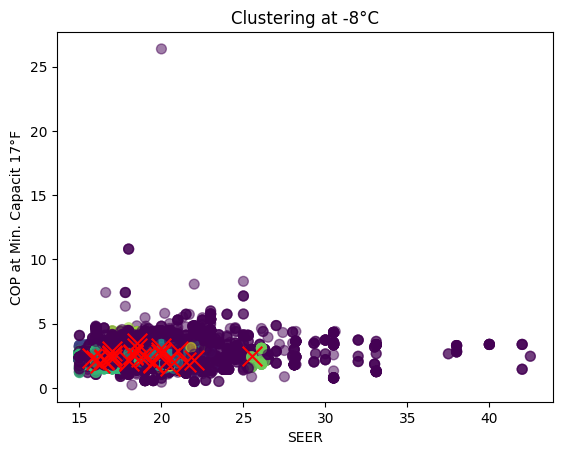

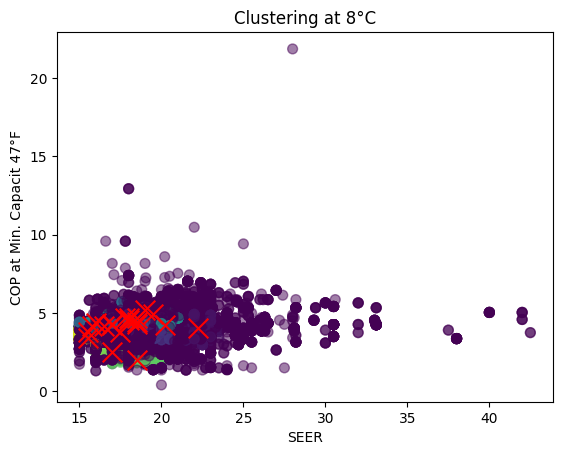

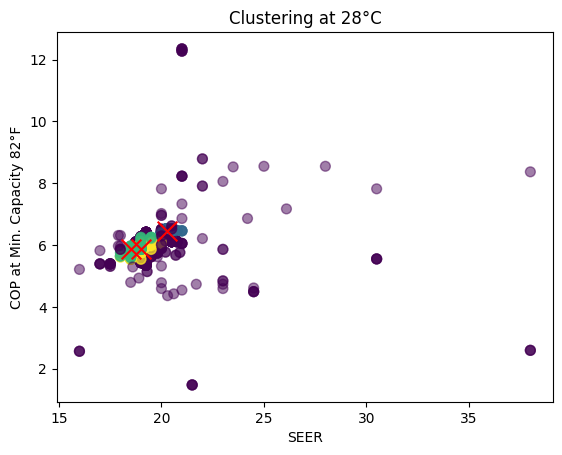

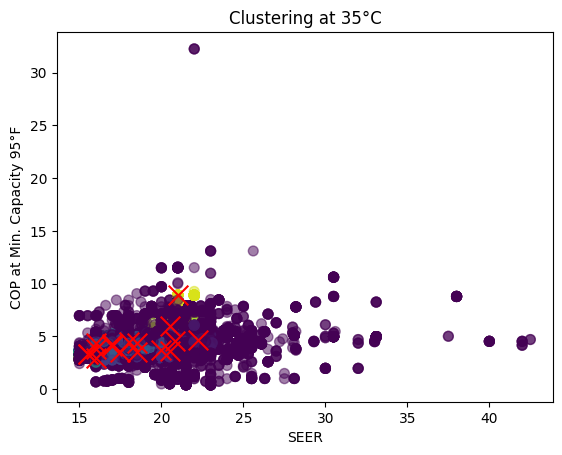

In [30]:
# Scatter plot for each model
for model_name in models:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(
        train_data[model_name].iloc[:, 0],
        train_data[model_name].iloc[:, 1],
        c=models[model_name].labels_,
        cmap='viridis',
        s=50,
        alpha=0.5
    )
    # Plot medoids in red
    medoids = get_medoids(models[model_name], train_data[model_name], n_clusters=len(set(models[model_name].labels_)) - (1 if -1 in models[model_name].labels_ else 0))
    medoids = np.array(medoids)
    ax.scatter(medoids[:, 0], medoids[:, 1], c='red', s=200, marker='x')

    # Display axis titles 
    ax.set_xlabel(train_data[model_name].columns[0])
    ax.set_ylabel(train_data[model_name].columns[1])
    plt.title(f"Clustering at {model_name_to_temp(model_name)}°C")

    plt.show()

In [ ]:
for model_name in models:
    print(f"{model_name}:")
    print(f"\tAverage distance to center: {average_distance_to_medoid(models[model_name], train_data[model_name]):.2f}")
    print(f"\tMax distance to center: {max_distance_to_medoid(models[model_name], train_data[model_name]):.2f}")

In [ ]:
# Find medoid datapoints in the original dataset
def get_medoids_in_dataset(model: DBSCAN, data: pd.DataFrame, dataset: pd.DataFrame) -> pd.DataFrame:
    medoids = get_medoids(model, data)
    medoids_df = pd.DataFrame(medoids, columns=data.columns)

    dataset_with_medoids = dataset[dataset.index.isin(medoids_df.index)]
    return dataset_with_medoids

In [ ]:
medoids = {}
for model_name in models:
    medoids[model_name] = get_medoids_in_dataset(models[model_name], train_data[model_name], dataset)

In [ ]:
medoids["kmeans_35"]["Ducting Configuration"]

# Plots

In [ ]:
# Perform PCA to plot data in 2D
def pca_plot(data: pd.DataFrame, model: DBSCAN) -> None:
    pca = PCA(n_components=2)
    pca.fit(data)
    data_pca = pca.transform(data)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.scatter(data_pca[:, 0], data_pca[:, 1], c=model.labels_, cmap='viridis', s=50, alpha=0.5)
    # Plot medoids in red
    medoids = get_medoids(model, data)
    medoids = np.array(medoids)
    medoids_pca = pca.transform(medoids)
    ax.scatter(medoids_pca[:, 0], medoids_pca[:, 1], c='red', s=200, marker='x')

    # Display axis titles 
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    plt.title(f"Clustering {model_name}")

    plt.show()

In [ ]:
for model_name in models:
    pca_plot(train_data[model_name], models[model_name])